In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
import xgboost
print(xgboost.__version__)

In [5]:
# Sube el archivo desde tu ordenador
from google.colab import files
uploaded = files.upload()

Saving oficial_test.csv to oficial_test.csv


In [3]:
import pandas as pd

# 1. Leer y preparar módulo 6
modulo6 = pd.read_csv("bajo_6_procesado.csv", parse_dates=["fecha"])

# 2. Leer y preparar datos oficiales
oficial = pd.read_csv("oficial.csv", parse_dates=["fecha"])
oficial = oficial.rename(columns={'PM2.5': 'PM2.5_ref', 'Ozono': 'O3_ref', 'NO2': 'NO2_ref'})

# 3. Validación de estructura temporal
assert len(modulo6) == len(oficial)
assert all(modulo6['fecha'].values == oficial['fecha'].values)

# 4. Merge por columnas
df_merged = pd.concat([modulo6, oficial.drop(columns='fecha')], axis=1)

# 5. Eliminar filas con valores nulos
df = df_merged.dropna()

# 6. Variables temporales
df['hora'] = df['fecha'].dt.hour
df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes'] = df['fecha'].dt.month

# 7. Variables predictoras
features = [
    'NO2', 'CO2', 'O3', 'CO', 'CH20',
    'Tª', 'Humedad', 'PM1.0', 'PM2.5', 'PM10.0',
    'hora', 'dia_semana', 'mes', 'VOC_cat'
]

print("Datos de entrenamiento preparados:", df.shape)





Datos de entrenamiento preparados: (20880, 45)


In [4]:
import pandas as pd

# 1. Leer y preparar módulo 6 de test
modulo6_test = pd.read_csv("bajo_test_6_procesado.csv", parse_dates=["fecha"])

# 2. Leer y preparar datos oficiales de test
oficial_test = pd.read_csv("oficial_test.csv", parse_dates=["fecha"])
oficial_test = oficial_test.rename(columns={'PM2.5': 'PM2.5_ref', 'Ozono': 'O3_ref', 'NO2': 'NO2_ref'})

# 3. Validación de estructura temporal
assert len(modulo6_test) == len(oficial_test)
assert all(modulo6_test['fecha'].values == oficial_test['fecha'].values)

# 4. Merge por columnas
df_merged_test = pd.concat([modulo6_test, oficial_test.drop(columns='fecha')], axis=1)

# 5. Eliminar nulos
df_test = df_merged_test.dropna()

# 6. Variables temporales
df_test['hora'] = df_test['fecha'].dt.hour
df_test['dia_semana'] = df_test['fecha'].dt.dayofweek
df_test['mes'] = df_test['fecha'].dt.month

# 7. Variables predictoras
features = [
    'NO2', 'CO2', 'O3', 'CO', 'CH20',
    'Tª', 'Humedad', 'PM1.0', 'PM2.5', 'PM10.0',
    'hora', 'dia_semana', 'mes', 'VOC_cat'
]

print("Datos de test preparados:", df_test.shape)




Datos de test preparados: (2160, 45)


In [5]:
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    mean_absolute_percentage_error, explained_variance_score
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

def entrenar_xgboost(df, features, target_var, sensor_var, nombre_modelo='xgboost_opt'):

    os.makedirs("graficas", exist_ok=True)

    # División entrenamiento/validación (80/20)
    split_index = int(len(df) * 0.8)
    X = df[features]
    y = df[target_var]
    X_train = X.iloc[:split_index]
    X_val = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_val = y.iloc[split_index:]

    # Modelo XGBoost ajustado para evitar overfitting
    model = XGBRegressor(
        n_estimators=1400,
        learning_rate=0.01,
        max_depth=2,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=0.1,
        reg_lambda=1.0,
        eval_metric='mae',
        random_state=42
    )

    eval_set = [(X_train, y_train), (X_val, y_val)]
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        verbose=False
    )

    # 🔍 Mejor iteración en validación
    evals_result = model.evals_result()
    val_mae = evals_result['validation_1']['mae']
    best_iter = np.argmin(val_mae)
    print(f"\n📉 Mejor iteración (mínimo MAE en validación): {best_iter}")

    # Predicciones solo hasta la mejor iteración
    y_train_pred = model.predict(X_train, iteration_range=(0, best_iter + 1))
    y_val_pred = model.predict(X_val, iteration_range=(0, best_iter + 1))

    # Métricas
    def eval_metrics(y_true, y_pred):
        return {
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred),
            'EVS': explained_variance_score(y_true, y_pred)
        }

    train_metrics = eval_metrics(y_train, y_train_pred)
    val_metrics = eval_metrics(y_val, y_val_pred)

    print(f"\n🔍 Resultados para {target_var} con XGBoost:")
    print("Entrenamiento:", train_metrics)
    print("Validación:", val_metrics)

    # Gráfica: comparación temporal
    plt.figure(figsize=(12, 5))
    plt.plot(y_val.values, label='Valor real', color='black')
    plt.plot(y_val_pred, label='Predicción XGBoost', color='blue')
    #if sensor_var and sensor_var in df.columns:
        #plt.plot(X_val[sensor_var].values, label=f'Sensor sin calibrar ({sensor_var})', color='orange')
    plt.title(f'Comparación temporal - {target_var}')
    plt.xlabel("Índice temporal")
    plt.ylabel(target_var)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'graficas/{target_var}_{nombre_modelo}_comparacion_temporal.png')
    plt.show()

    # Gráfica: pred vs real
    plt.figure(figsize=(6, 6))
    plt.scatter(y_val, y_val_pred, alpha=0.6)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel("Valor real")
    plt.ylabel("Predicción")
    plt.title(f"Predicción vs Real - {target_var}")
    plt.tight_layout()
    plt.savefig(f'graficas/{target_var}_{nombre_modelo}_pred_vs_real.png')
    plt.show()

    # Gráfica: residuos
    residuos = y_val - y_val_pred
    plt.figure(figsize=(10, 4))
    plt.scatter(y_val_pred, residuos, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicción")
    plt.ylabel("Residuo")
    plt.title(f"Gráfico de residuos - {target_var}")
    plt.tight_layout()
    plt.savefig(f'graficas/{target_var}_{nombre_modelo}_residuos.png')
    plt.show()

    # Gráfica: importancia de variables
    plt.figure(figsize=(8, 5))
    plot_importance(model, height=0.5, importance_type='gain')
    plt.title(f"Importancia de variables - {target_var}")
    plt.tight_layout()
    plt.savefig(f'graficas/{target_var}_{nombre_modelo}_importancia.png')
    plt.show()

    # Gráfica: curva de pérdida
    plt.figure(figsize=(8, 5))
    plt.plot(evals_result['validation_0']['mae'], label='Entrenamiento')
    plt.plot(val_mae, label='Validación')
    plt.axvline(best_iter, color='red', linestyle='--', label='Mejor iteración')
    plt.xlabel('Iteraciones')
    plt.ylabel('MAE')
    plt.title('Curva de pérdida - XGBoost')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'graficas/{target_var}_{nombre_modelo}_loss_curve.png')
    plt.show()

    return model, train_metrics, val_metrics



📉 Mejor iteración (mínimo MAE en validación): 1398

🔍 Resultados para O3_ref con XGBoost:
Entrenamiento: {'RMSE': np.float64(13.894252307784784), 'MAE': 10.451569557189941, 'R2': 0.7314246892929077, 'MAPE': 105954200780800.0, 'EVS': 0.7314247278138988}
Validación: {'RMSE': np.float64(15.186489746652954), 'MAE': 12.14067554473877, 'R2': 0.6617848873138428, 'MAPE': 0.3871835768222809, 'EVS': 0.6695340294779527}


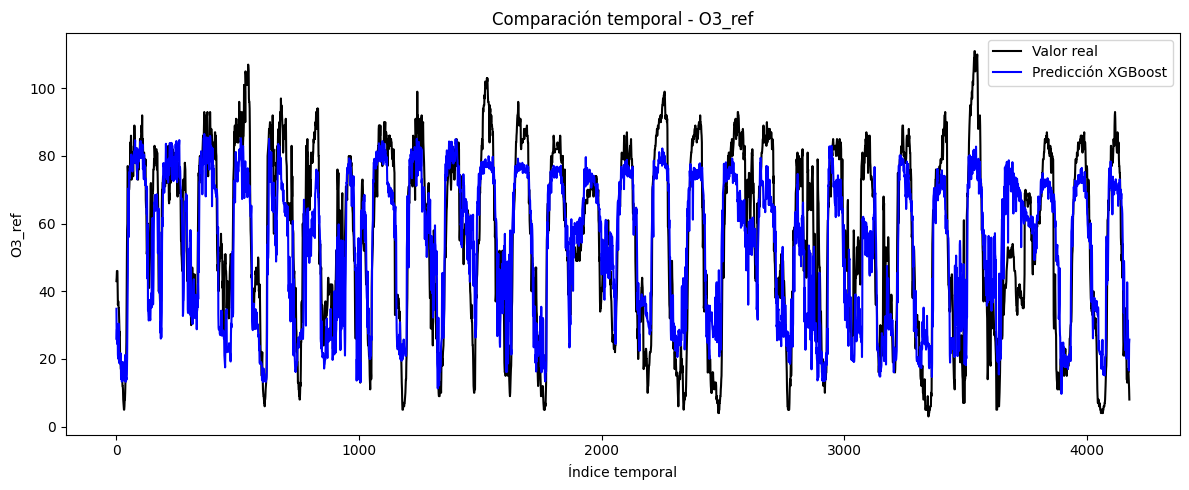

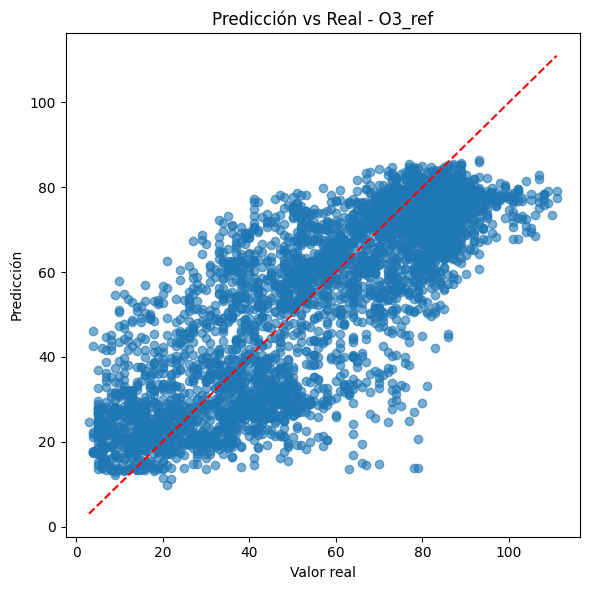

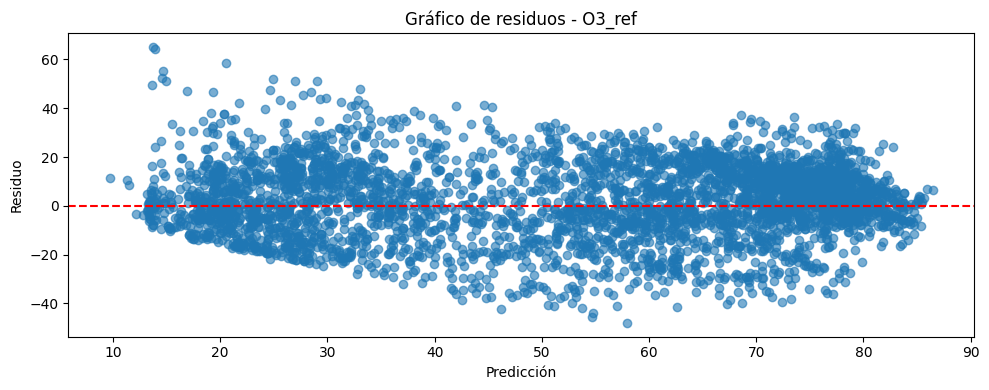

<Figure size 800x500 with 0 Axes>

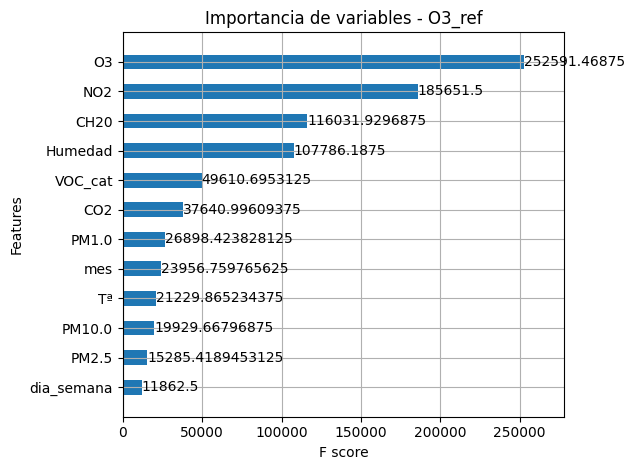

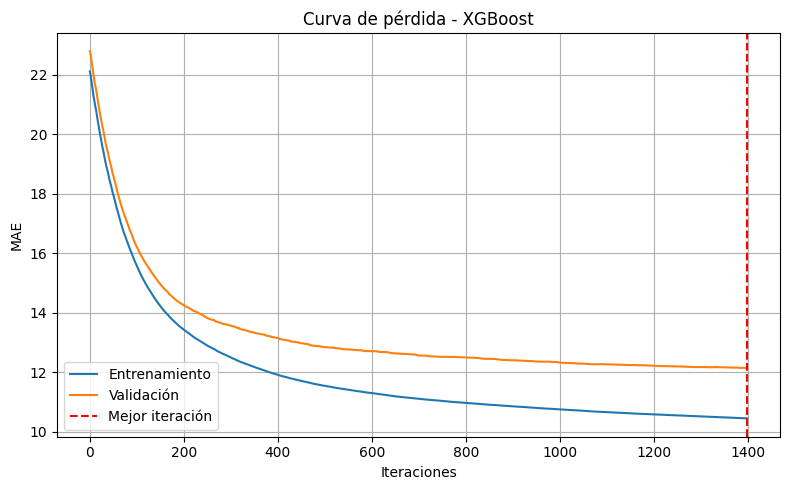

In [10]:
# Entrenamiento
model, train_metrics, val_metrics = entrenar_xgboost(
    df=df,
    features=features,
    target_var='O3_ref',
    sensor_var='O3',
    nombre_modelo='xgboost_mejorado'
)


🧪 Resultados en conjunto de TEST:
{'RMSE': np.float64(26.134959973424486), 'MAE': 22.050643920898438, 'R2': -0.19897842407226562, 'MAPE': 1.7578312158584595, 'EVS': 0.5895959811171991}


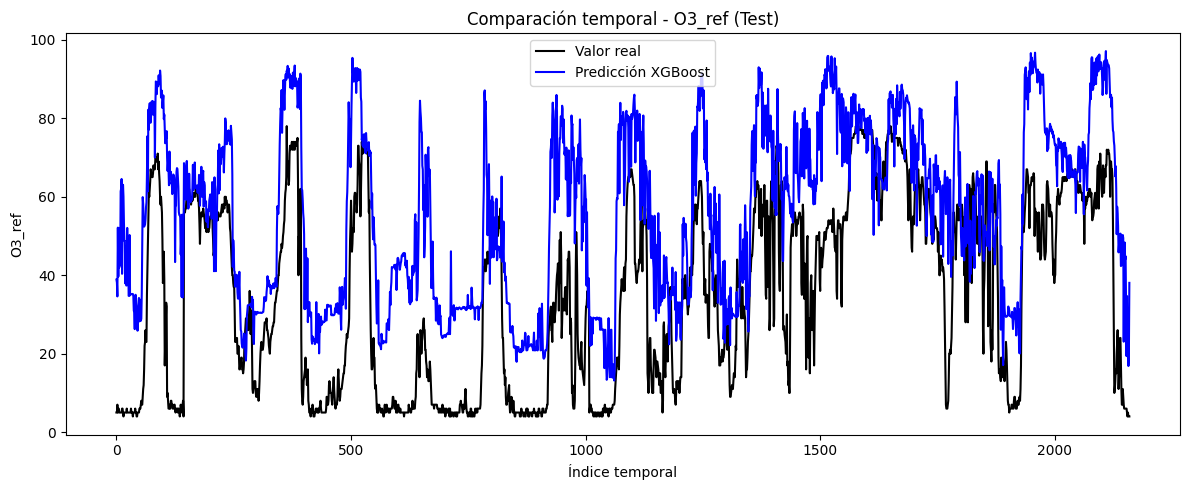

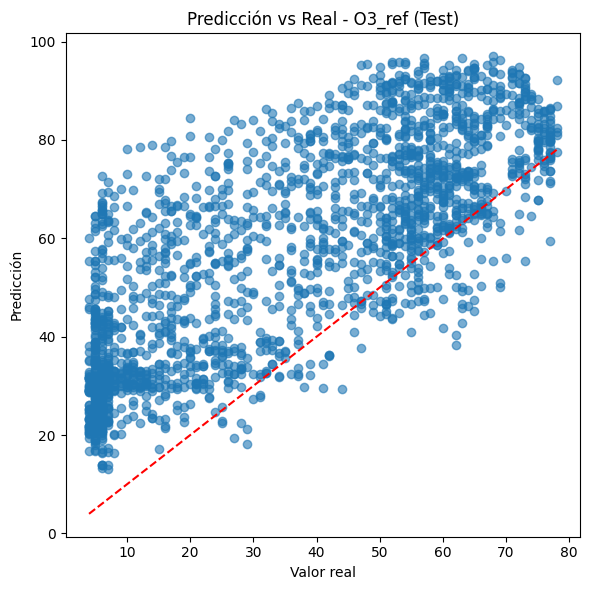

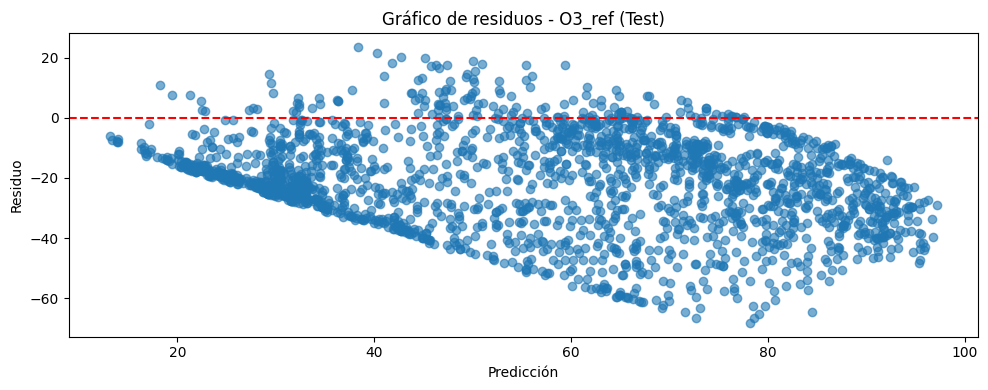

In [11]:
# Evaluación en conjunto de test para O3_ref
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score
import numpy as np
import matplotlib.pyplot as plt
import os

# Asegurar que el directorio para guardar gráficas existe
os.makedirs("graficas", exist_ok=True)

# Preparar X_test e y_test
X_test = df_test[features]
y_test = df_test['O3_ref']

# Obtener número total de iteraciones usadas en entrenamiento
num_iter = model.get_booster().best_ntree_limit if hasattr(model.get_booster(), "best_ntree_limit") else model.n_estimators

# Predicciones
y_test_pred = model.predict(X_test, iteration_range=(0, num_iter))

# Métricas en test
test_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'MAE': mean_absolute_error(y_test, y_test_pred),
    'R2': r2_score(y_test, y_test_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_test_pred),
    'EVS': explained_variance_score(y_test, y_test_pred)
}

print("\n🧪 Resultados en conjunto de TEST:")
print(test_metrics)

# Gráfica: comparación temporal
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Valor real', color='black')
plt.plot(y_test_pred, label='Predicción XGBoost', color='blue')
plt.title('Comparación temporal - O3_ref (Test)')
plt.xlabel("Índice temporal")
plt.ylabel("O3_ref")
plt.legend()
plt.tight_layout()
plt.savefig('graficas/O3_ref_xgboost_mejorado_test_comparacion_temporal.png')
plt.show()

# Gráfica: pred vs real
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicción vs Real - O3_ref (Test)")
plt.tight_layout()
plt.savefig('graficas/O3_ref_xgboost_mejorado_test_pred_vs_real.png')
plt.show()

# Gráfica: residuos
residuos_test = y_test - y_test_pred
plt.figure(figsize=(10, 4))
plt.scatter(y_test_pred, residuos_test, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicción")
plt.ylabel("Residuo")
plt.title("Gráfico de residuos - O3_ref (Test)")
plt.tight_layout()
plt.savefig('graficas/O3_ref_xgboost_mejorado_test_residuos.png')
plt.show()



In [18]:
import shutil
from google.colab import files

# Crear un archivo ZIP con todo el contenido de la carpeta 'graficas'
shutil.make_archive('graficas', 'zip', 'graficas')

# Descargar el archivo ZIP
files.download('graficas.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    mean_absolute_percentage_error, explained_variance_score
)

def entrenar_xgboost(df, features, target_var, sensor_var=None, nombre_modelo='xgboost_opt'):
    os.makedirs("graficas", exist_ok=True)

    # División temporal
    split_index = int(len(df) * 0.8)
    X = df[features]
    y = df[target_var]
    X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]

    # Modelo base
    model = XGBRegressor(
        n_estimators=1400,
        learning_rate=0.01,
        max_depth=2,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=0.1,
        reg_lambda=1.0,
        eval_metric='mae',
        random_state=42
    )

    eval_set = [(X_train, y_train), (X_val, y_val)]
    model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

    evals_result = model.evals_result()
    best_iter = np.argmin(evals_result['validation_1']['mae'])

    y_train_pred = model.predict(X_train, iteration_range=(0, best_iter + 1))
    y_val_pred = model.predict(X_val, iteration_range=(0, best_iter + 1))

    def eval_metrics(y_true, y_pred):
        return {
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred),
            'EVS': explained_variance_score(y_true, y_pred)
        }

    train_metrics = eval_metrics(y_train, y_train_pred)
    val_metrics = eval_metrics(y_val, y_val_pred)

    return model, train_metrics, val_metrics, best_iter

def entrenar_modelo_con_correccion(df, df_test, features, target_var='O3_ref', sensor_var='O3'):
    os.makedirs("graficas", exist_ok=True)

    # Paso 1: entrenar modelo base
    modelo_base, train_metrics, val_metrics, best_iter = entrenar_xgboost(
        df=df,
        features=features,
        target_var=target_var,
        sensor_var=sensor_var,
        nombre_modelo='base'
    )

    # Paso 2: calcular residuos
    split_index = int(len(df) * 0.8)
    X = df[features]
    y = df[target_var]
    X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]

    y_train_pred = modelo_base.predict(X_train, iteration_range=(0, best_iter + 1))
    y_val_pred = modelo_base.predict(X_val, iteration_range=(0, best_iter + 1))

    residuo_train = y_train - y_train_pred
    residuo_val = y_val - y_val_pred

    # Paso 3: entrenar modelo de corrección
    modelo_residuo = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=2,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42
    )
    modelo_residuo.fit(X_train, residuo_train)

    # Paso 4: predecir corrección
    residuo_train_pred = modelo_residuo.predict(X_train)
    residuo_val_pred = modelo_residuo.predict(X_val)

    y_train_corr = y_train_pred + residuo_train_pred
    y_val_corr = y_val_pred + residuo_val_pred

    def eval_metrics(y_true, y_pred):
        return {
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred),
            'EVS': explained_variance_score(y_true, y_pred)
        }

    train_corr_metrics = eval_metrics(y_train, y_train_corr)
    val_corr_metrics = eval_metrics(y_val, y_val_corr)

    print("\n✅ Resultados tras corrección del error:")
    print("Entrenamiento corregido:", train_corr_metrics)
    print("Validación corregida:", val_corr_metrics)

    # Paso 5: evaluación en test
    X_test = df_test[features]
    y_test = df_test[target_var]
    y_test_base = modelo_base.predict(X_test, iteration_range=(0, best_iter + 1))
    residuo_test_pred = modelo_residuo.predict(X_test)
    y_test_corr = y_test_base + residuo_test_pred

    test_base_metrics = eval_metrics(y_test, y_test_base)
    test_corr_metrics = eval_metrics(y_test, y_test_corr)

    print("\n📊 Resultados en conjunto de TEST:")
    print("Base:", test_base_metrics)
    print("Corregido:", test_corr_metrics)

    # Paso 6: gráficas
    plt.figure(figsize=(12, 5))
    plt.plot(y_val.values, label="Valor real", color="black")
    plt.plot(y_val_pred, label="Predicción base", color="blue")
    plt.plot(y_val_corr, label="Predicción corregida", color="green")
    plt.title("Comparación temporal - Validación (base vs corregida)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("graficas/O3_ref_comparacion_corregida.png")
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.scatter(y_val, y_val_corr, alpha=0.6)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel("Valor real")
    plt.ylabel("Predicción corregida")
    plt.title("Predicción vs Real (corregida) - Validación")
    plt.tight_layout()
    plt.savefig("graficas/O3_ref_corregido_pred_vs_real.png")
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.scatter(y_val_corr, y_val - y_val_corr, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicción corregida")
    plt.ylabel("Residuo")
    plt.title("Residuos (corregido) - Validación")
    plt.tight_layout()
    plt.savefig("graficas/O3_ref_corregido_residuos.png")
    plt.show()

    return modelo_base, modelo_residuo, train_corr_metrics, val_corr_metrics, test_base_metrics, test_corr_metrics



✅ Resultados tras corrección del error:
Entrenamiento corregido: {'RMSE': np.float64(12.779286576537574), 'MAE': 9.601147651672363, 'R2': 0.7727996706962585, 'MAPE': 103599845670912.0, 'EVS': 0.7727996908595124}
Validación corregida: {'RMSE': np.float64(15.37731023039709), 'MAE': 12.422971725463867, 'R2': 0.6532320976257324, 'MAPE': 0.31698453426361084, 'EVS': 0.7169056893324163}

📊 Resultados en conjunto de TEST:
Base: {'RMSE': np.float64(26.140057618618354), 'MAE': 22.055269241333008, 'R2': -0.19944632053375244, 'MAPE': 1.757859706878662, 'EVS': 0.5895376348204158}
Corregido: {'RMSE': np.float64(25.253185713328822), 'MAE': 21.07078742980957, 'R2': -0.1194380521774292, 'MAPE': 1.5875651836395264, 'EVS': 0.5956738776625623}


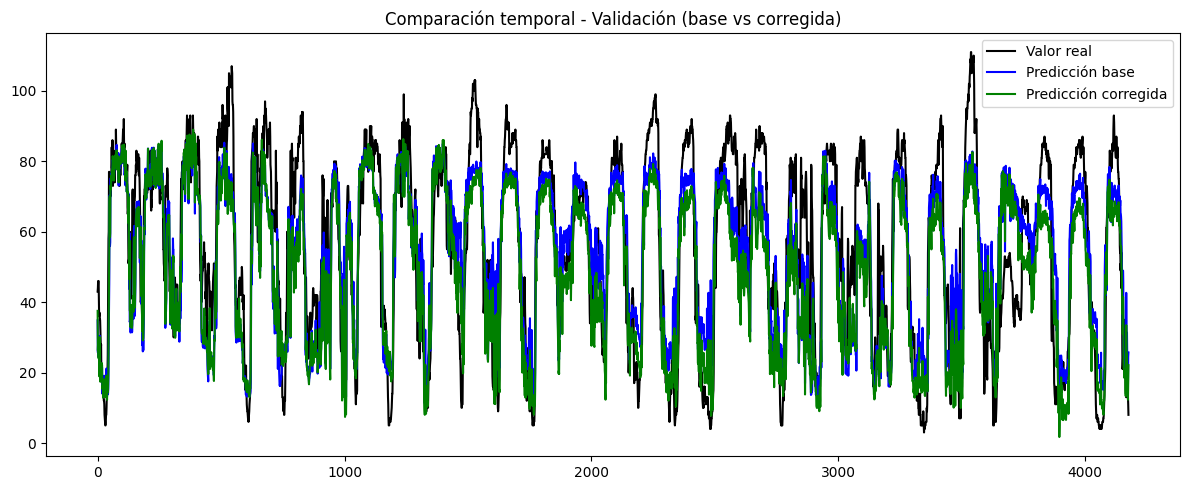

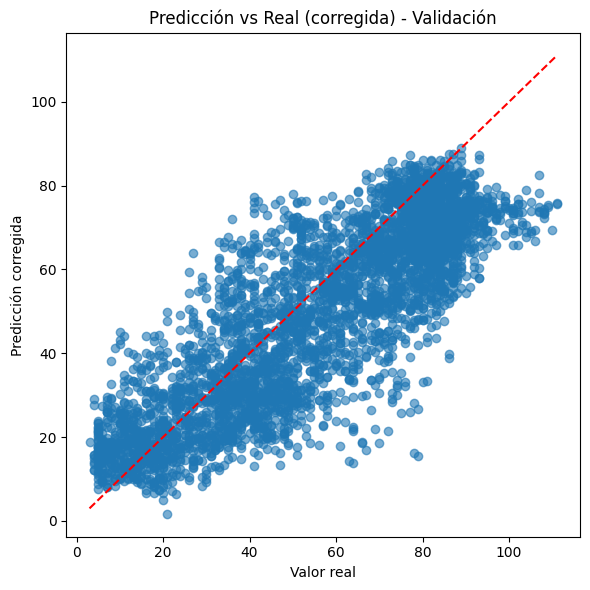

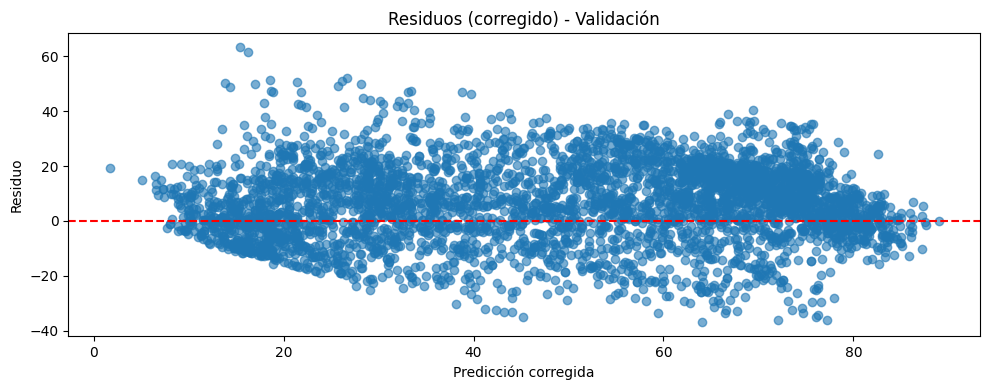

In [17]:
modelo_base, modelo_residuo, train_corr, val_corr, test_base, test_corr = entrenar_modelo_con_correccion(
    df=df,
    df_test=df_test,
    features=features,
    target_var='O3_ref',
    sensor_var='O3'
)
